In [51]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
df = pd.read_csv("cardio_train.csv", delimiter=";").drop("id", axis=1)

### a) Hur många är positiva för häart-kärlsjukdom och hur många är negativa?

In [52]:
df["age"] = (df["age"]/365).round()
df["cardio"].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

### b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden?


In [53]:
chol_list = df["cholesterol"].value_counts()
type(chol_list) # pandas.core.series.Series
for i in range(1, 4):
    print(f"Andel: {i}. {chol_list[i]/len(df):.1%}")
chol_list[2]

Andel: 1. 74.8%
Andel: 2. 13.6%
Andel: 3. 11.5%


9549

###  c) Hur ser åldersfördelningen ut?

In [54]:
df_age = (df["age"]/365).round(1)

In [60]:
df["age"].nsmallest(5)

6219     30.0
22343    30.0
30666    30.0
55905    30.0
118      39.0
Name: age, dtype: float64

### d) Hur stor andel röker?

### e) Hur ser viktfördelningen ut?


### f) Hur ser längdfördelningen ut?

In [ ]:
age_filter = df["age"] > 39
df = df[age_filter]
weight_filter = df["weight"] > 45
df = df[weight_filter]
height_filter = df["height"] > 145
df = df[height_filter]

smokers = df[df["smoke"] == 1]
smoke_prop = len(smokers) / len(df)

print(f"{smoke_prop = :.2%}")

### g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom?

In [15]:
women = df[df["gender"] == 1]
men = df[df["gender"] == 2]
num_women_cardio = len(women[women["cardio"] == 1])
num_men_cardio = len(men[men["cardio"] == 1])
print(f"{num_women_cardio/len(df) = :.2%} | {num_men_cardio/len(df) = :.2%}")

num_women_cardio = 22203 | num_men_cardio = 12290
num_women_cardio/len(df) = 32.32% | num_men_cardio/len(df) = 17.89%


# !!!!!!!!!!!!!! Sammanfatta dina resultat och presentera dem i en notebook. Anv¨and markdown boxar f¨or l¨opande text.

# 1.2 Modelldesign

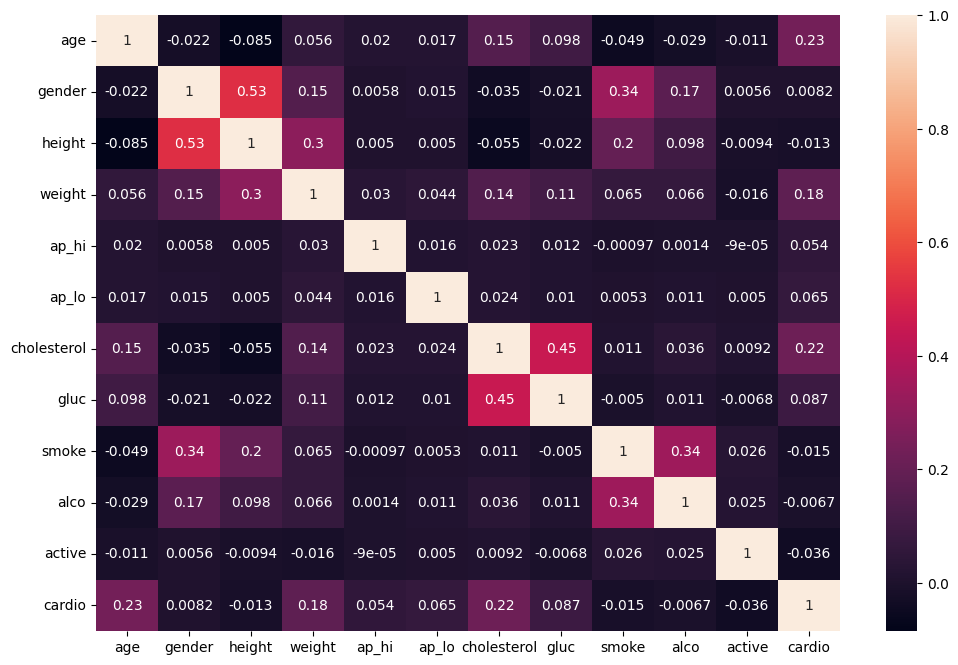

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

# 1.2.1 Feature Engineering

$$BMI = \frac{kg}{m^2}$$


In [47]:
df["BMI"] = df["weight"] / (df["height"]/100)**2
df.head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI,class_bl_press
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,21.96712,Normal range,normal_press


### a) Sl¨ang de samples med orimliga BMIer och outliers. Notera att detta kanvara sv˚art att avg¨ora i vilket range av BMIer som vi ska spara. Beskriv hur du kommer fram till gr¨anserna, med resonemang eller referens.

### b) Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese (class II), obese (class III).

In [46]:
bmi_bins = [18.5, 25, 30, 35, 40, float('inf')]

# Definiera kategorierna för varje BMI-intervall
bmi_categories = ['Normal range', 'Overweight', 'Obese (Class 1)', 
                  'Obese (Class 2)', 'Obese (Class 3)']

# Skapa en ny kolumn "class_BMI" baserat på kategoriseringen av BMI-värden
df["class_BMI"] = pd.cut(df["BMI"], bins=bmi_bins, labels=bmi_categories, right=False)
df.dropna(inplace=True)

### c) Unders¨ok om kategorin ¨ar relevant, dvs dess korrelationer. Uppdatera data-analysen om du hittar n˚agot intressant.

#### c) Unders¨ok om kategorin ¨ar relevant, dvs dess korrelationer. Uppdatera data-analysen om du hittar n˚agot intressant.

BMI påverkar Cardio med 0.19, kan vara  nåt intressant ???????

### Skapa en feature f¨or blodtryckskategorier enligt tabellen i denna artikel.
a) Sl¨ang bort samples med orimliga blodtryck och outliers. Likt f¨orra uppgiften ¨ar det inte trivialt att s¨atta gr¨anserna. Beskriv hur du kommer fram
till gr¨anserna. https://www.ncbi.nlm.nih.gov/books/NBK570233/table/ch1.tab1/

In [22]:
filter_outliers_ap = ((df["ap_hi"] > 70) & (df["ap_hi"] < 250) & (df["ap_lo"] > 40) & (df["ap_lo"] < 150))
df = df[filter_outliers_ap]

(67054, 14)

### b) Skapa en kategorisk feature med relevanta kategorier. https://www.ncbi.nlm.nih.gov/books/NBK570233/table/ch1.tab1/
https://en.wikipedia.org/wiki/Blood_pressure

In [23]:
# definiera kategorier
conditions = [
    (df["ap_hi"] < 90) | (df["ap_lo"] < 60),   # low_press
    (df["ap_hi"] >= 140) | (df["ap_lo"] > 90), # High_press
    (df["ap_hi"] <= 120) & (df["ap_lo"] <= 80),  # normal_press
    ((df["ap_hi"] > 120) & (df["ap_hi"] < 140)) | ((df["ap_lo"] > 80) & (df["ap_lo"] < 90)) # High_norm
]
# kategorier
categories = ["low_press", "high_press", "normal_press", "high_normal"]
# klassa
df["class_bl_press"] = np.select(conditions, categories, default=None)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [45]:
df_encoded = pd.get_dummies(df, columns = ["class_BMI", "class_bl_press"], dtype=int)

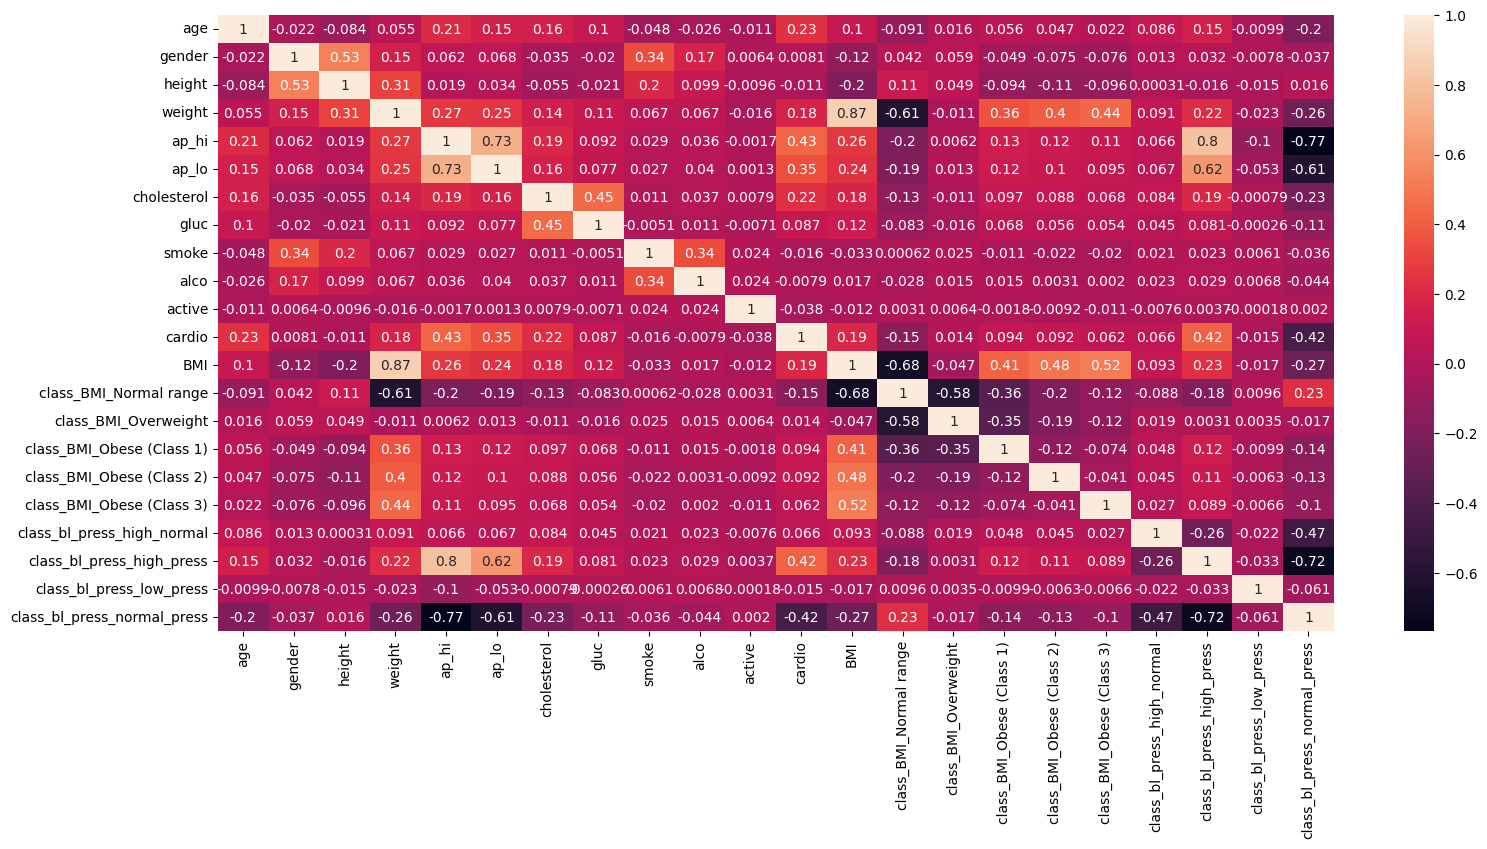

In [25]:
plt.figure(figsize=(18, 8))
sns.heatmap(df_encoded.corr(), annot=True)
plt.show()

# !!!!!!!!!!!!!!!!!!!!!!!!!!
## Enligt vår heatmap fick vi veta att på "Cardio" dvs hjärtsjukdomar påverkar följande kolumner: high_bl_press, BMI, chol, weight och age.

###   ap_High på cardio ??????????????????????

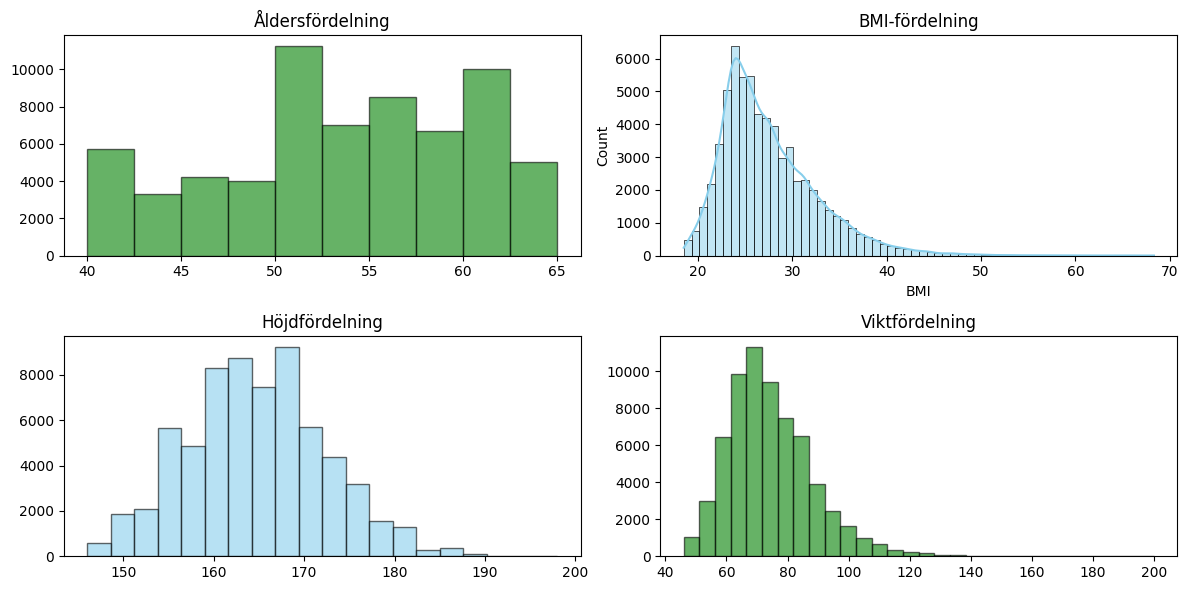

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
# Age
axs[0, 0].hist(df["age"], bins=10, color='green', edgecolor='black', alpha=0.6)
axs[0, 0].set_title('Åldersfördelning')
# BMI
sns.histplot(df["BMI"], kde=True, bins=60, color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title('BMI-fördelning')
# Height
axs[1, 0].hist(df["height"], bins=20, color='skyblue', edgecolor='black', alpha=0.6)
axs[1, 0].set_title('Höjdfördelning')
# Weight
axs[1, 1].hist(df["weight"], bins=30, color='green', edgecolor='black', alpha=0.6)
axs[1, 1].set_title('Viktfördelning')
plt.tight_layout()

# 1.2.2 Skapa tv˚a dataset


In [27]:
df_1 = df.drop(["ap_hi", "ap_lo", "height", "weight", "BMI"], axis = "columns")
encod_df_1 = pd.get_dummies(df_1, columns = ["class_BMI", "class_bl_press", "gender"], dtype=int)
# 2
df_2 = df.drop(["class_BMI", "class_bl_press", "height", "weight"], axis = "columns")
encod_df_2 = pd.get_dummies(df_2, columns = ["gender"], dtype=int)

# 1.2.3 Utf¨orande


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [29]:
X, y = encod_df_1.drop("cardio", axis=1), encod_df_1["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
pipe_forest = make_pipeline(scaler, RandomForestClassifier())
pipe_knn = make_pipeline(scaler, KNeighborsClassifier())
pipe_log = make_pipeline(scaler, LogisticRegression(solver="saga", max_iter=10000, penalty="elasticnet", multi_class="auto"))
param_grid_forest = {
    "randomforestclassifier__n_estimators": list(range(50, 200, 10)),
    "randomforestclassifier__max_depth": np.arange(1, 10, 2)
} 
param_grid_knn = {"kneighborsclassifier__n_neighbors": list(range(1, 50))}
param_grid_log = {"logisticregression__l1_ratio": np.linspace(0, 1, 20)}


## forest

In [30]:
classifier_forest = GridSearchCV(estimator=pipe_forest, param_grid = param_grid_forest, cv=5, scoring="accuracy", n_jobs=-1)
classifier_forest.fit(X_train, y_train)
classifier_knn = GridSearchCV(estimator=pipe_knn, param_grid = param_grid_knn, cv=5, scoring="accuracy", n_jobs=-1)
classifier_knn.fit(X_train, y_train)
classifier_log = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, cv=5, scoring="accuracy", n_jobs=-1)
classifier_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='accuracy')

In [31]:
y_pred_forest = classifier_forest.predict(X_test)
y_pred_knn = classifier_knn.predict(X_test)
y_pred_log = classifier_log.predict(X_test)

# encod_df_2

In [32]:
X, y = encod_df_2.drop("cardio", axis=1), encod_df_2["cardio"]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.33, random_state=42)

# Train/fit

In [33]:
classifier_forest_2 = GridSearchCV(estimator=pipe_forest, param_grid = param_grid_forest, cv=5, scoring="accuracy", n_jobs=-1)
classifier_forest_2.fit(X_train_2, y_train_2)
classifier_knn_2 = GridSearchCV(estimator=pipe_knn, param_grid = param_grid_knn, cv=5, scoring="accuracy", n_jobs=-1)
classifier_knn_2.fit(X_train_2, y_train_2)
classifier_log_2 = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, cv=5, scoring="accuracy", n_jobs=-1)
classifier_log_2.fit(X_train_2, y_train_2)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='accuracy')

# Predict

In [34]:
y_pred_forest_2 = classifier_forest_2.predict(X_test_2)
y_pred_knn_2 = classifier_knn_2.predict(X_test_2)
y_pred_log_2 = classifier_log_2.predict(X_test_2)

## confusion_matrix

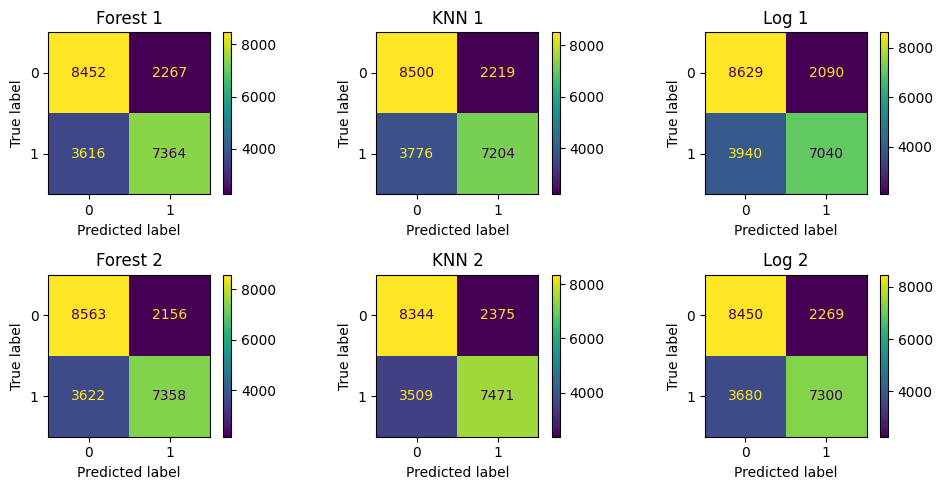

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
# Forest
cm_forest = confusion_matrix(y_test, y_pred_forest)
disp1 = ConfusionMatrixDisplay(cm_forest)
disp1.plot(ax=axs[0, 0])
axs[0, 0].set_title('Forest 1')
# knn
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp2 = ConfusionMatrixDisplay(cm_knn)
disp2.plot(ax=axs[0, 1])
axs[0, 1].set_title('KNN 1')
# log
cm_log = confusion_matrix(y_test, y_pred_log)
disp3 = ConfusionMatrixDisplay(cm_log)
disp3.plot(ax=axs[0, 2])
axs[0, 2].set_title('Log 1')

# forest_2
cm_forest_2 = confusion_matrix(y_test_2, y_pred_forest_2)
disp1 = ConfusionMatrixDisplay(cm_forest_2)
disp1.plot(ax=axs[1, 0])
axs[1, 0].set_title('Forest 2')
# knn_2
cm_knn_2 = confusion_matrix(y_test_2, y_pred_knn_2)
disp2 = ConfusionMatrixDisplay(cm_knn_2)
disp2.plot(ax=axs[1, 1])
axs[1, 1].set_title('KNN 2')
# log_2
cm_log_2 = confusion_matrix(y_test_2, y_pred_log_2)
disp3 = ConfusionMatrixDisplay(cm_log_2)
disp3.plot(ax=axs[1, 2])
axs[1, 2].set_title('Log 2')
plt.tight_layout()

# 1.3 Paketering och demo

### KNN bäst med 49 neighbors

In [38]:
X, y = encod_df_2.drop("cardio", axis=1), encod_df_1["cardio"]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=100, random_state=42)

In [39]:
test_samples = pd.concat([X_test_3, y_test_3], axis=1)
test_samples.to_csv("test_samples.csv", index=False)

In [40]:
classifier_knn_2 = GridSearchCV(estimator=pipe_knn, param_grid = param_grid_knn, cv=5, scoring="accuracy", n_jobs=-1)
classifier_knn_2.fit(X_train_3, y_train_3)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               20, 21, 22, 23,
                                                               24, 25, 26, 27,
                                                               28, 29, 30, ...]},
             scoring='accuracy')

In [44]:
classifier_knn_2.best_params_, classifier_knn_2.best_estimator_.get_params() 

({'kneighborsclassifier__n_neighbors': 39},
 {'memory': None,
  'steps': [('standardscaler', StandardScaler()),
   ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=39))],
  'verbose': False,
  'standardscaler': StandardScaler(),
  'kneighborsclassifier': KNeighborsClassifier(n_neighbors=39),
  'standardscaler__copy': True,
  'standardscaler__with_mean': True,
  'standardscaler__with_std': True,
  'kneighborsclassifier__algorithm': 'auto',
  'kneighborsclassifier__leaf_size': 30,
  'kneighborsclassifier__metric': 'minkowski',
  'kneighborsclassifier__metric_params': None,
  'kneighborsclassifier__n_jobs': None,
  'kneighborsclassifier__n_neighbors': 39,
  'kneighborsclassifier__p': 2,
  'kneighborsclassifier__weights': 'uniform'})

### Save

In [41]:
from joblib import dump
dump(classifier_knn_2, 'classifier_knn_2.pkl')

['classifier_knn_2.pkl']